# 05_Mapping_distance_from_roots.ipynb

For each method for each cell type:
- Get distance from the origin
- Get distance from the center of TAC-1

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/cchu/Desktop/phd_work/hyperChromatin/src/PoincareMaps')

import os
workdir = '../results/05'
os.makedirs(workdir, exist_ok=True)


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import torch 
from refs import celltype_colors
import matplotlib.pyplot as plt
from IPython.display import Image
from run_poincare_map import features_names

from main import *
from poincare_maps import *

features_names

{'RNA PCA': '../results/02/rna_pca.celltype_label',
 'RNA Simba': '../results/02/rna_simba.celltype_label',
 'ATAC PCA': '../results/02/atac_pca.celltype_label',
 'ATAC PCA (standard)': '../results/02/atac_std_pca.celltype_label',
 'ATAC Simba': '../results/02/atac_simba.celltype_label',
 'Simba Multi': '../results/02/multi_simba.celltype_label'}

In [3]:
def get_rotated_poincare_coord(poincare_coord_df, features_df, root="TAC-1"):
    model = PoincareMaps(poincare_coord_df[['x', 'y']].values)
    labels = poincare_coord_df['labels'].values
    model.iroot = poincare_root(root, labels, features_df.drop(columns=['labels']).values) 
    model.rotate()
    df = pd.DataFrame(model.coordinates_rotated, columns=['x', 'y'])
    df['labels'] = poincare_coord_df['labels'].values
    return df

In [4]:
rna_pca_name = '../results/03/rna_pca.celltype_label'
rna_simba_name = '../results/03/rna_simba.celltype_label'
atac_pca_name = '../results/03/atac_std_pca.celltype_label'
atac_simba_name = '../results/03/atac_simba.celltype_label'
simba_multi_name = '../results/03/multi_simba.celltype_label'

names = [rna_pca_name, rna_simba_name, atac_pca_name, atac_simba_name, simba_multi_name]

poincare_results = {
    "RNA PCA": rna_pca_name, "RNA Simba": rna_simba_name, 
    "ATAC PCA (standard)": atac_pca_name, "ATAC Simba": atac_simba_name, 
    "Simba Multi": simba_multi_name
}

In [5]:
root = "TAC-1"
annot_poincare_coord_dfs = []
for name, fn in poincare_results.items():
    poincare_coord_df = pd.read_csv(f"{fn}.ep500_lr0.1.poincare_coord.labeled.csv", sep=',')
    poincare_coord_df['dist_from_origin'] = poincare_coord_df[['x', 'y']].apply(
        lambda coor: poin_dist(
            torch.tensor(coor.to_numpy(), dtype=torch.float32),
            torch.tensor([0, 0], dtype=torch.float32)
        ).detach().numpy(), axis=1).astype(float)
    
    features_df = pd.read_csv(f"{fn.replace('03', '02')}.csv", sep=',') # different folder
    rotated_poincare_coord_df = get_rotated_poincare_coord(poincare_coord_df, features_df, root=root)

    poincare_coord_df[f'dist_from_{root}'] = rotated_poincare_coord_df[['x', 'y']].apply(
        lambda coor: poin_dist(
            torch.tensor(coor.to_numpy(), dtype=torch.float32),
            torch.tensor([0, 0], dtype=torch.float32)
        ).detach().numpy(), axis=1).astype(float)

    poincare_coord_df['name'] = name
    annot_poincare_coord_dfs.append(poincare_coord_df)

In [6]:
concat_annot_poincare_coord_dfs = pd.concat(annot_poincare_coord_dfs)

In [7]:
concat_annot_poincare_coord_fn = f"{workdir}/dist_from_origins.csv"
print(concat_annot_poincare_coord_fn)
concat_annot_poincare_coord_dfs.to_csv(concat_annot_poincare_coord_fn, index=False)


../results/05/dist_from_origins.csv


In [8]:
concat_annot_poincare_coord_dfs

,x,y,labels,dist_from_origin,dist_from_TAC-1,name
0,-0.041638,-0.006655,TAC-1,0.084382,0.059359,RNA PCA
1,-0.107620,0.002094,TAC-1,0.216119,0.176808,RNA PCA
2,0.031848,-0.027072,TAC-1,0.083649,0.117622,RNA PCA
3,-0.092457,0.012742,TAC-1,0.187207,0.160049,RNA PCA
4,-0.052169,-0.081695,TAC-1,0.194473,0.111875,RNA PCA
...,...,...,...,...,...,...
6431,-0.030961,0.019797,TAC-2,0.073532,0.420982,Simba Multi
6432,0.116407,0.215752,TAC-1,0.500497,0.245015,Simba Multi
6433,0.302629,-0.128221,TAC-2,0.682676,0.586310,Simba Multi
6434,0.055994,0.193045,TAC-1,0.407551,0.277414,Simba Multi


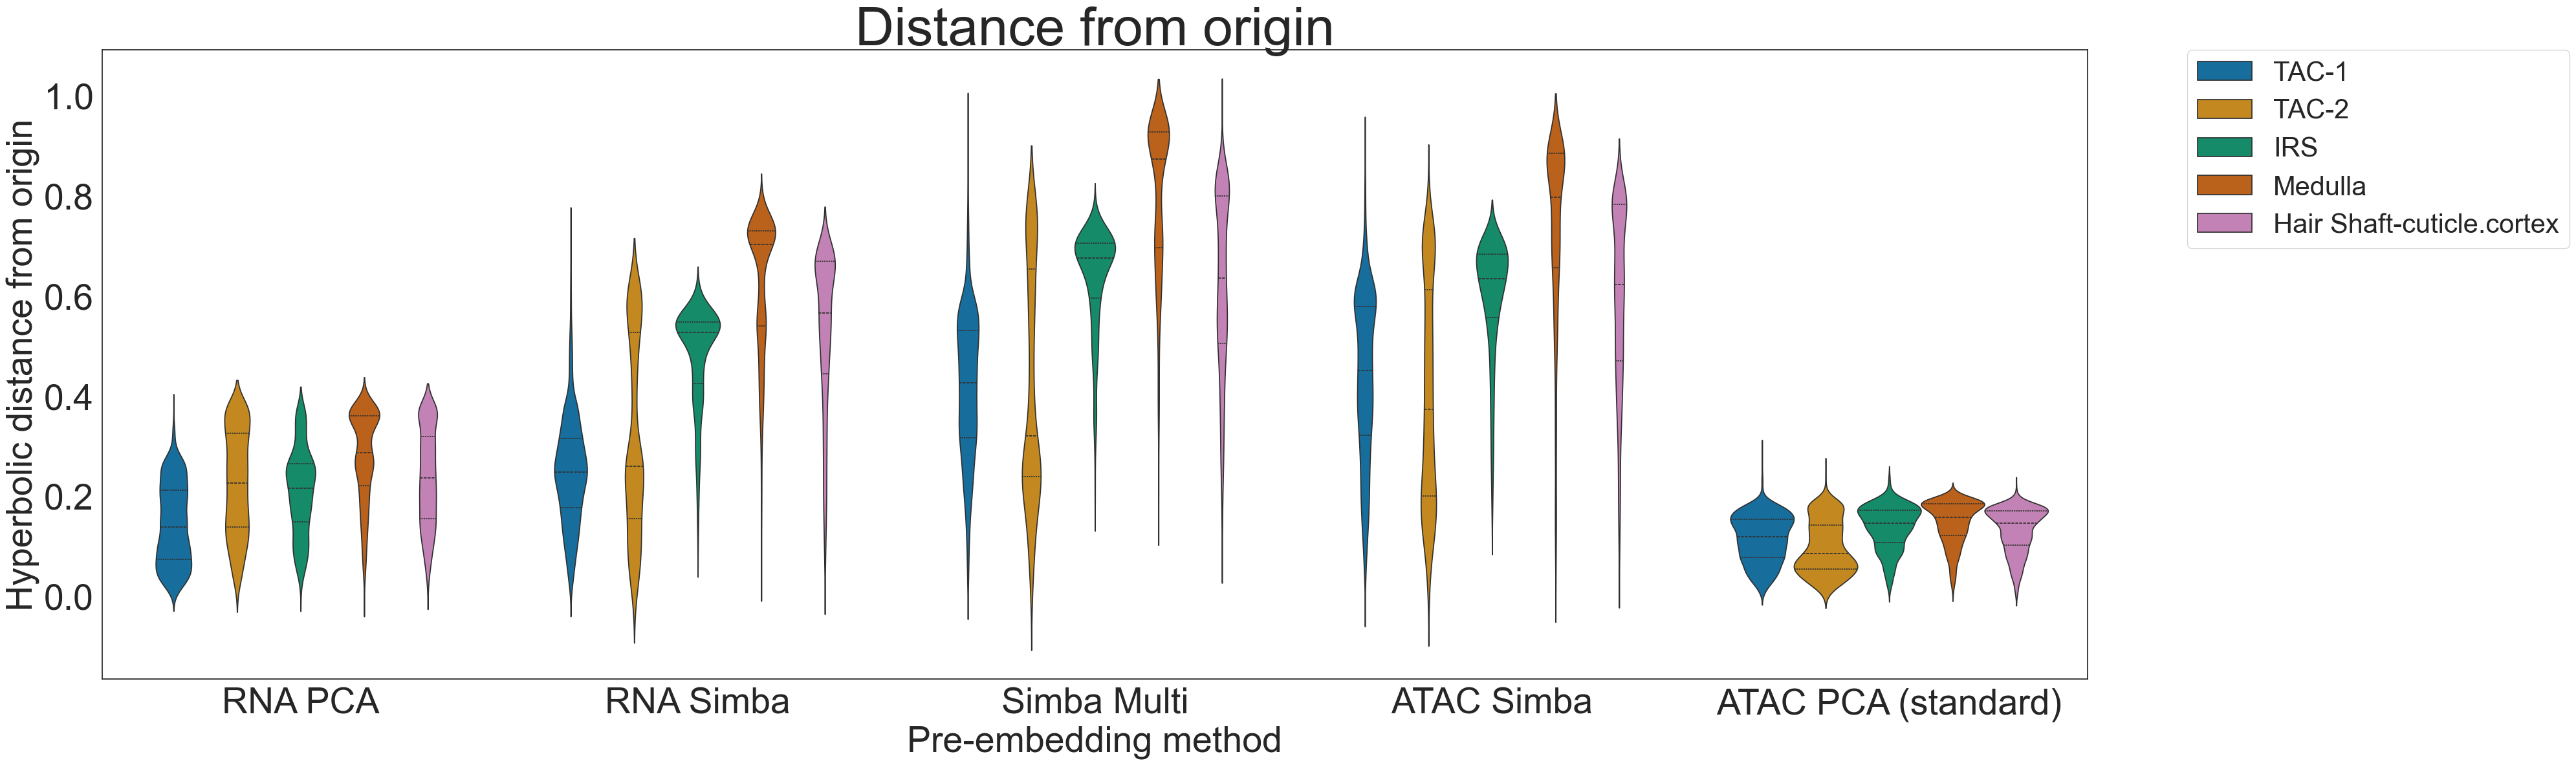

In [34]:
fig, ax = plt.subplots(figsize=(40, 12))
sns.violinplot(
    data=concat_annot_poincare_coord_dfs, 
    x='name', y='dist_from_origin', 
    hue='labels', hue_order=list(celltype_colors.keys()), ax=ax, 
    palette=celltype_colors, inner="quart", order=["RNA PCA", "RNA Simba", "Simba Multi", "ATAC Simba", "ATAC PCA (standard)"]
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.ylabel('Hyperbolic distance from origin', fontsize=40)
plt.xlabel('Pre-embedding method', fontsize=40)
plt.title('Distance from origin', fontsize=60)
plt.tight_layout()
plt.show()

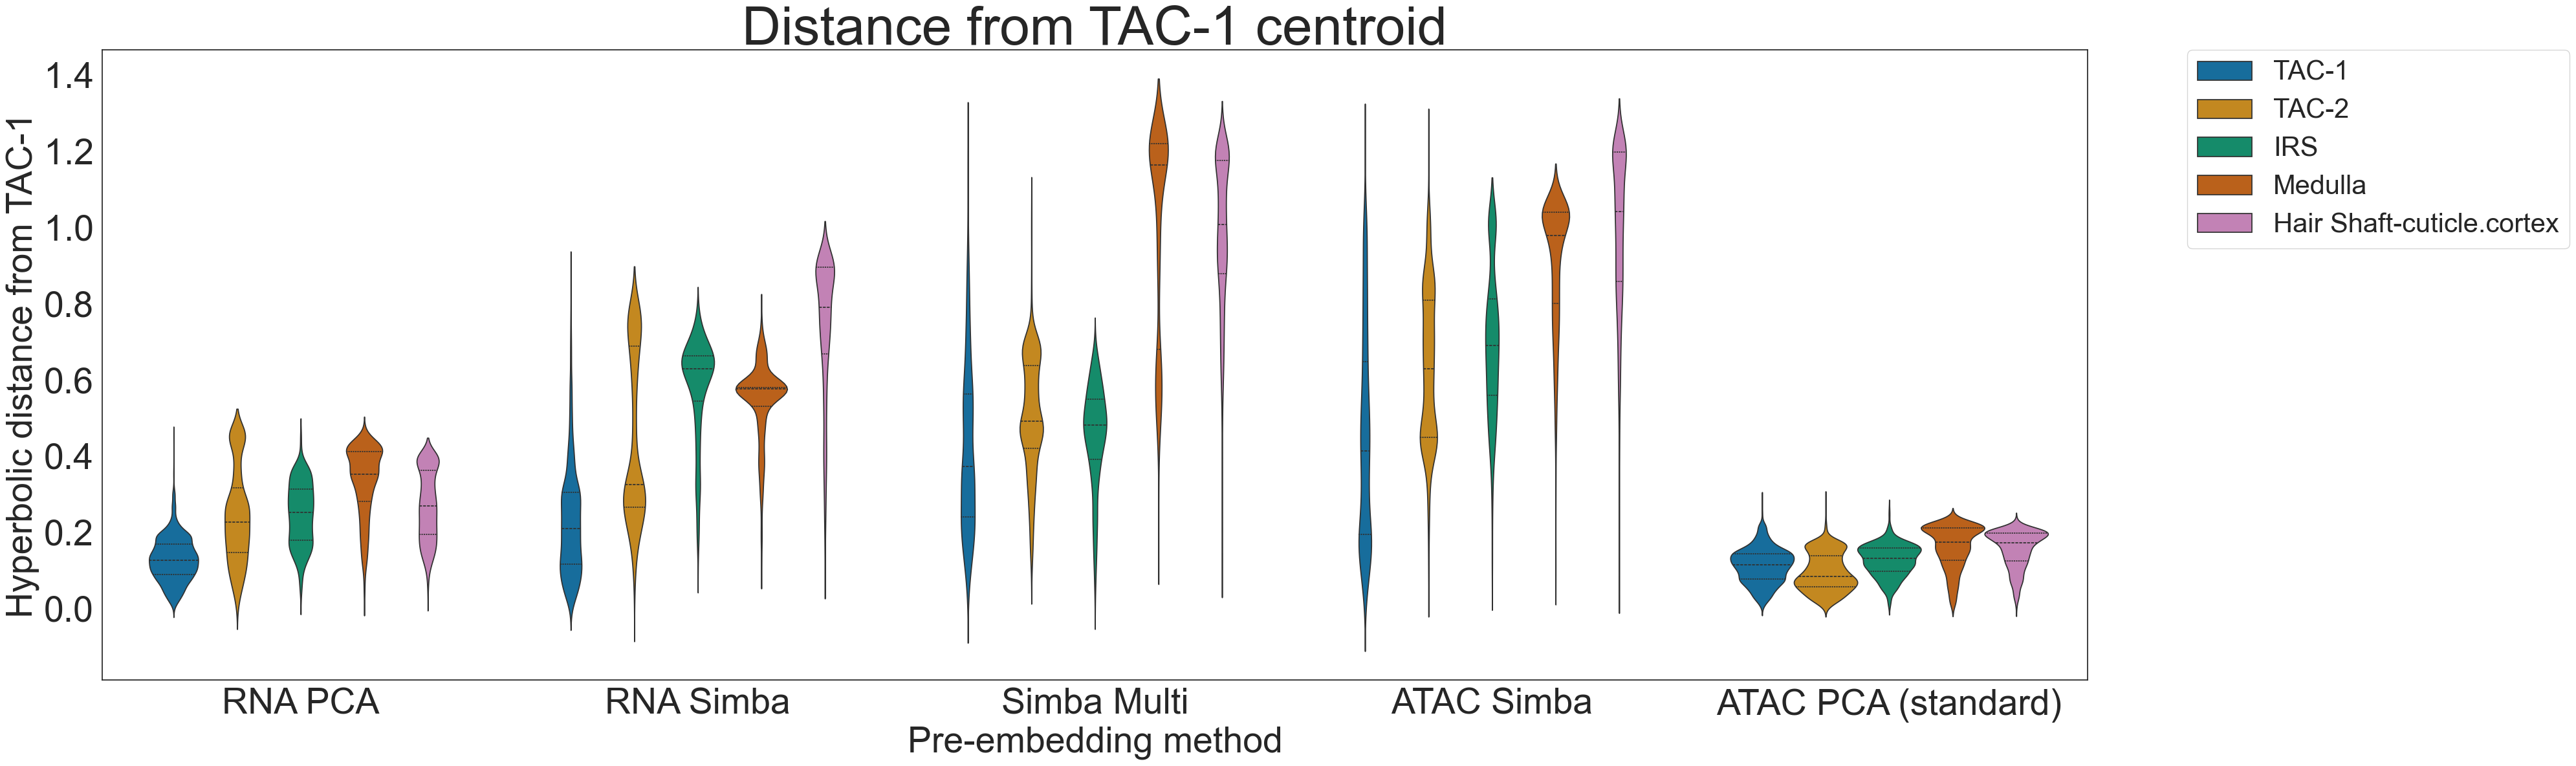

In [35]:
fig, ax = plt.subplots(figsize=(40, 12))
sns.violinplot(
    data=concat_annot_poincare_coord_dfs, 
    x='name', y='dist_from_TAC-1', 
    hue='labels', hue_order=list(celltype_colors.keys()), ax=ax, 
    palette=celltype_colors, inner="quart", order=["RNA PCA", "RNA Simba", "Simba Multi", "ATAC Simba", "ATAC PCA (standard)"]
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.ylabel('Hyperbolic distance from TAC-1', fontsize=40)
plt.xlabel('Pre-embedding method', fontsize=40)
plt.title('Distance from TAC-1 centroid', fontsize=60)
plt.tight_layout()

plt.show()